In [1]:
import pandas_datareader.data as web
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.stattools as ts 
from statsmodels.tsa.stattools import adfuller
from itertools import combinations
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import requests

In [3]:
%%capture
%run -i -e Cluster_deepdive.ipynb

KeyError: 'BRO'

KeyError: 'BRO'

In [61]:
# Print or use the top 10 pairs
print("Top 10 pairs with highest correlation and cointegration:")
for pair in top_10_pairs:
    print(pair)

Top 10 pairs with highest correlation and cointegration:
('BRO', 'ZTS', 0.9872539475201655, 0.9996754900648204)
('COST', 'ZTS', 0.9866689911492998, 0.999023192430264)
('PLD', 'ZTS', 0.9861061829689225, 0.9989619947674974)
('MMC', 'PLD', 0.9853229335760536, 0.9994233163868774)
('AWK', 'NEE', 0.9868568115394872, 0.9978297037556406)
('COST', 'PLD', 0.9839194239137584, 0.9995571098213761)
('MMC', 'RSG', 0.9842816727576015, 0.9984326844212785)
('BRO', 'PLD', 0.9844181942072598, 0.9978592778337858)
('BRO', 'COST', 0.9828831474486409, 0.9989811576799048)
('DG', 'WMT', 0.981937974031105, 0.999923208176514)


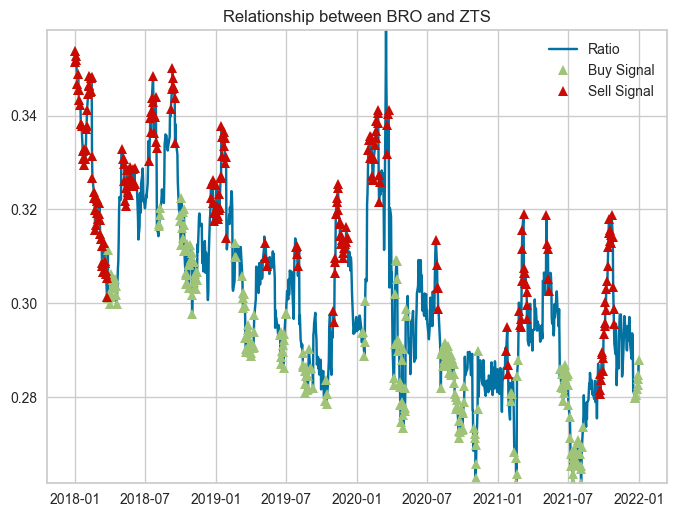

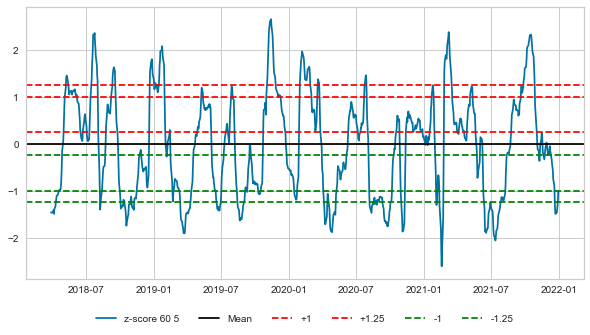

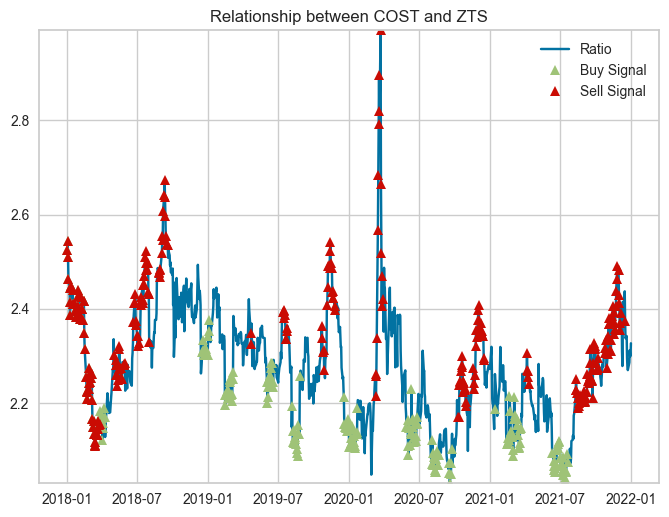

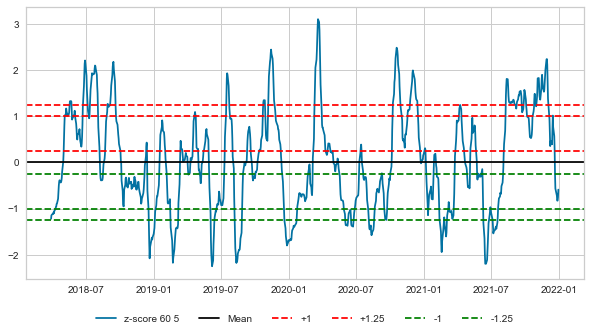

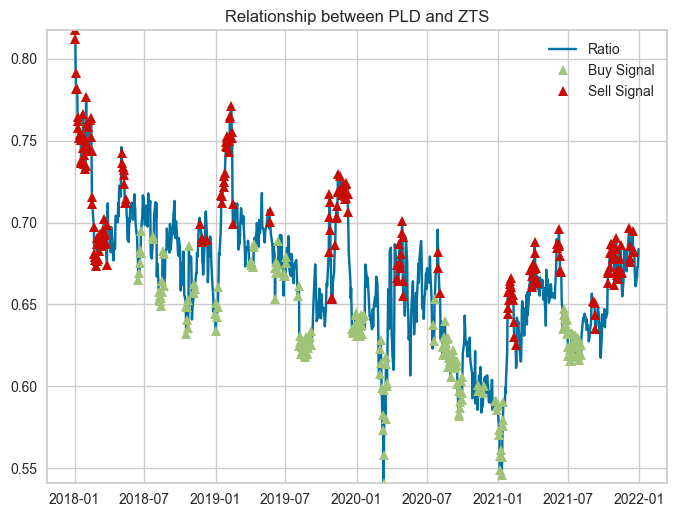

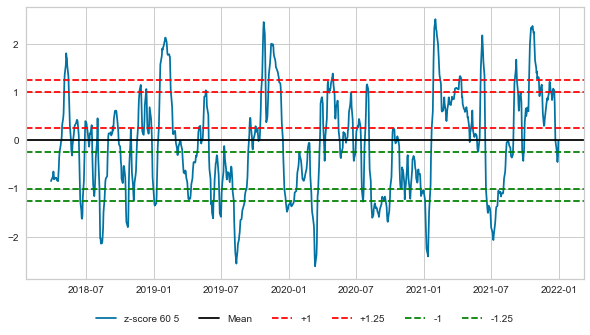

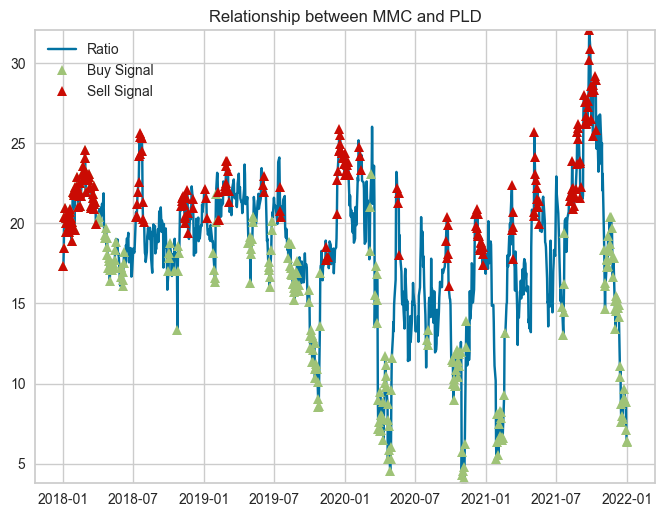

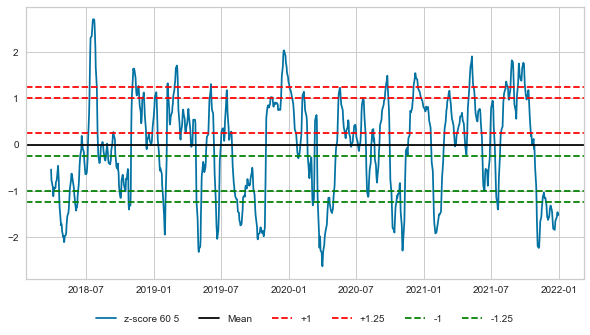

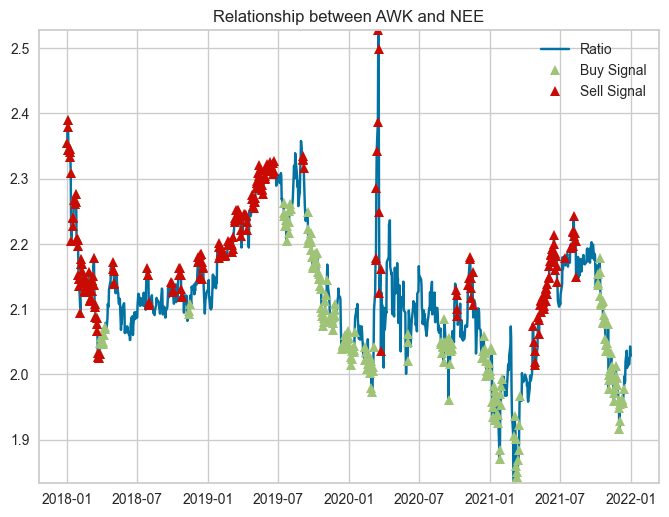

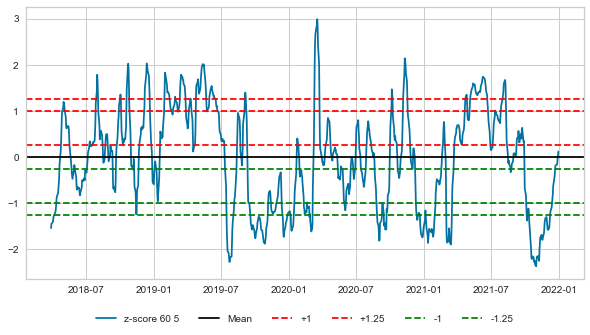

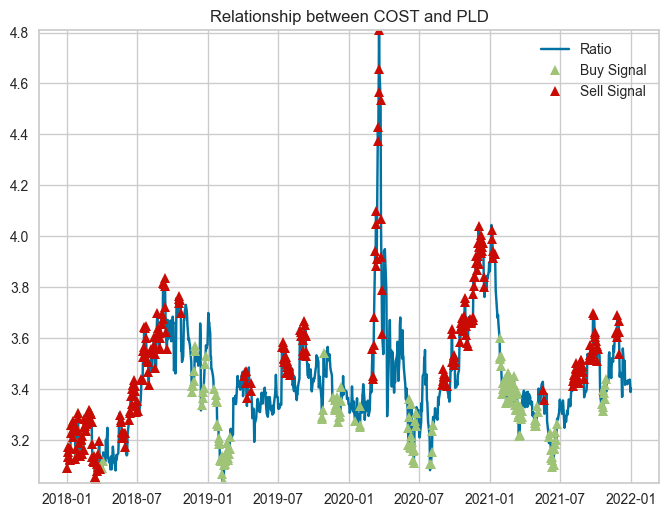

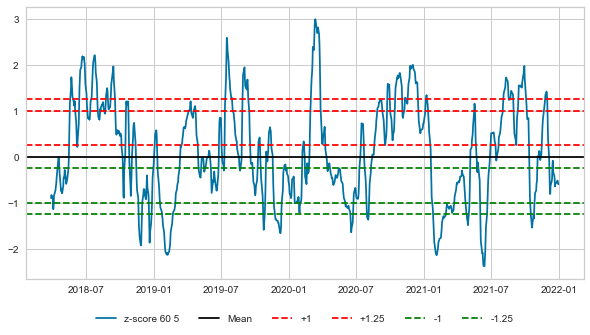

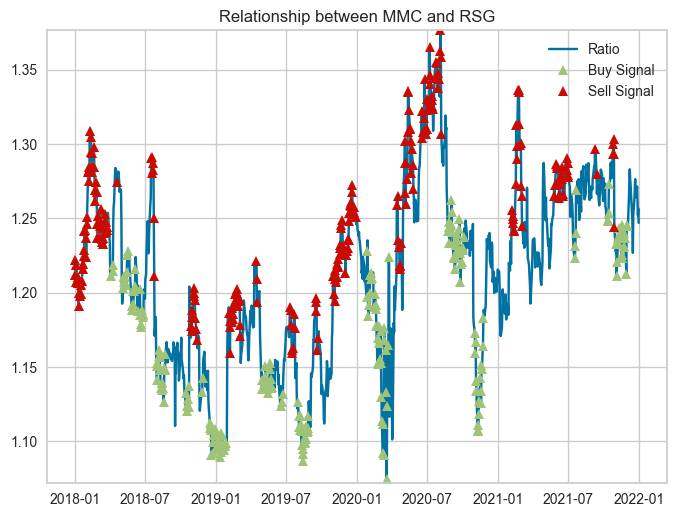

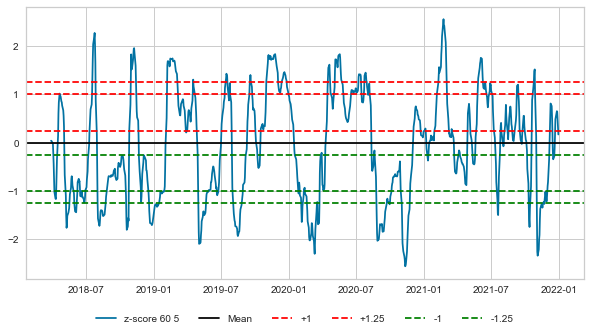

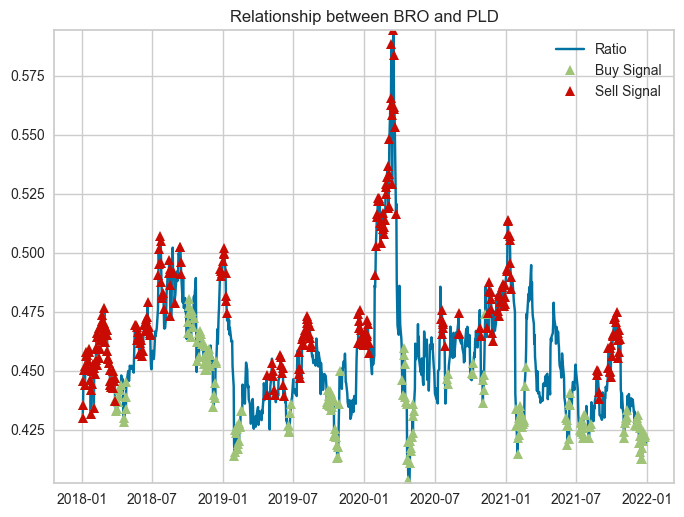

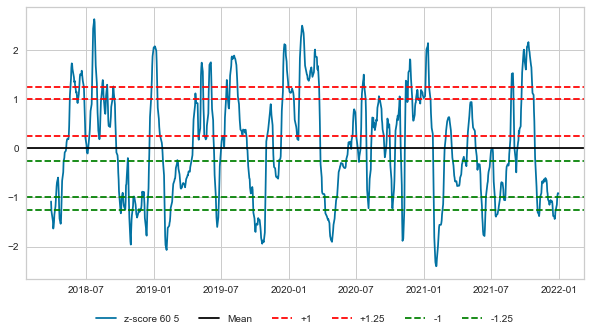

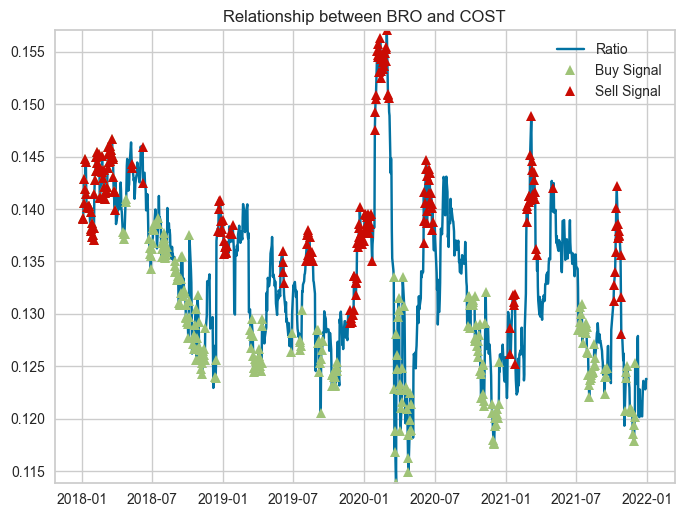

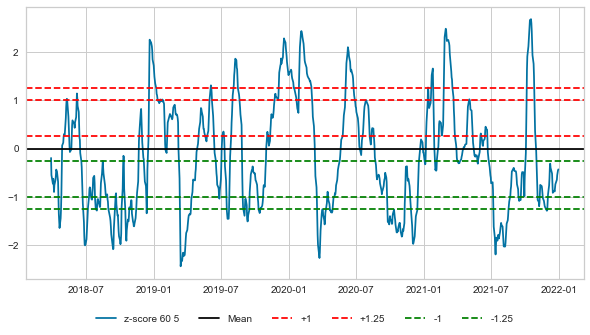

In [62]:
for pair in top_10_pairs:
    # Cointgration test
    stock_1 = preferred_cluster[pair[0]]
    stock_2 = preferred_cluster[pair[1]]
    result = ts.coint(stock_1, stock_2)
    
    cointegration_t_statistic = result[0]
    p_val = result[1]
    critical_values_test_statistic_at_1_5_10 = result[2]
    
    if p_val < 0.05:
        # Dickey-Fuller Test
        first_ADF = adfuller(stock_1)
        second_ADF = adfuller(stock_2)
        Spread_ADF = adfuller(stock_1 - stock_2)
        Ratio_ADF = adfuller(stock_1 / stock_2)
        
        ratio, min_ratio = None, None

        if Spread_ADF[1] < Ratio_ADF[1]:
            ratio = stock_1 - stock_2
            min_ratio = Spread_ADF[1]
        elif Spread_ADF[1] > Ratio_ADF[1]:
            ratio = stock_1 / stock_2
            min_ratio = Ratio_ADF[1]

        if min_ratio < 0.05:
            # Create a signals
            ratios_mavg5 = ratio.rolling(window=5, center=False).mean()
            ratios_mavg60 = ratio.rolling(window=60, center=False).mean()

            std_60 = ratio.rolling(window=60, center=False).std()
            zscore_60_5 = (ratios_mavg5 - ratios_mavg60)/std_60

            plt.figure(figsize=(8, 6), dpi=100)
            plt.plot(ratio)
            buy = ratio.copy()
            sell = ratio.copy()
            buy[zscore_60_5>-1] = np.nan
            sell[zscore_60_5<1] = np.nan

            plt.plot(buy, color='g', linestyle='None', marker='^')
            plt.plot(sell, color='r', linestyle='None', marker='^')

            x1, x2, y1, y2 = plt.axis()
            plt.axis((x1, x2, ratio.min(), ratio.max()))
            plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
            plt.title(f'Relationship between {pair[0]} and {pair[1]}')
            plt.show()


            plt.figure(figsize=(10, 5))
            plt.plot(zscore_60_5)
            plt.axhline(0, color='black')
            plt.axhline(1, color='red', linestyle='--')
            plt.axhline(1.25, color='red', linestyle='--')
            plt.axhline(-1, color='green', linestyle='--')
            plt.axhline(-1.25, color='green', linestyle='--')
            plt.axhline(0.25, color='red', linestyle='--')
            plt.axhline(-0.25, color='green', linestyle='--')
            plt.legend(['z-score 60 5', 'Mean', '+1','+1.25','-1','-1.25'], loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=6)
            plt.show()

In [87]:
trading_pairs = top_10_pairs.copy()
print(top_10_pairs)
print(trading_pairs)

[('BRO', 'ZTS', 0.9872539475201655, 0.9996754900648204), ('COST', 'ZTS', 0.9866689911492998, 0.999023192430264), ('PLD', 'ZTS', 0.9861061829689225, 0.9989619947674974), ('MMC', 'PLD', 0.9853229335760536, 0.9994233163868774), ('AWK', 'NEE', 0.9868568115394872, 0.9978297037556406), ('COST', 'PLD', 0.9839194239137584, 0.9995571098213761), ('MMC', 'RSG', 0.9842816727576015, 0.9984326844212785), ('BRO', 'PLD', 0.9844181942072598, 0.9978592778337858), ('BRO', 'COST', 0.9828831474486409, 0.9989811576799048), ('DG', 'WMT', 0.981937974031105, 0.999923208176514)]
[('BRO', 'ZTS', 0.9872539475201655, 0.9996754900648204), ('COST', 'ZTS', 0.9866689911492998, 0.999023192430264), ('PLD', 'ZTS', 0.9861061829689225, 0.9989619947674974), ('MMC', 'PLD', 0.9853229335760536, 0.9994233163868774), ('AWK', 'NEE', 0.9868568115394872, 0.9978297037556406), ('COST', 'PLD', 0.9839194239137584, 0.9995571098213761), ('MMC', 'RSG', 0.9842816727576015, 0.9984326844212785), ('BRO', 'PLD', 0.9844181942072598, 0.997859277

In [88]:
# Trading strategy
total_profit = 0
total_trade_vol = 0
total_order_fees = 0
transaction_list = []
trade_profit_list = []
for pair in trading_pairs:
    # Cointgration test
    stock_1 = preferred_cluster[pair[0]]
    stock_2 = preferred_cluster[pair[1]]
    result = ts.coint(stock_1, stock_2)
    
    cointegration_t_statistic = result[0]
    p_val = result[1]
    critical_values_test_statistic_at_1_5_10 = result[2]
    
    if p_val < 0.05:
        # Dickey-Fuller Test
        first_ADF = adfuller(stock_1)
        second_ADF = adfuller(stock_2)
        Spread_ADF = adfuller(stock_1 - stock_2)
        Ratio_ADF = adfuller(stock_1 / stock_2)
        
        ratio, min_ratio = None, None

        if Spread_ADF[1] < Ratio_ADF[1]:
            ratio = stock_1 - stock_2
            min_ratio = Spread_ADF[1]
        elif Spread_ADF[1] > Ratio_ADF[1]:
            ratio = stock_1 / stock_2
            min_ratio = Ratio_ADF[1]

        if min_ratio < 0.05:
            # Create a signals
            ratios_mavg5 = ratio.rolling(window=5, center=False).mean()
            ratios_mavg60 = ratio.rolling(window=60, center=False).mean()

            std_60 = ratio.rolling(window=60, center=False).std()
            zscore_60_5 = (ratios_mavg5 - ratios_mavg60)/std_60


        # only trade pairs with p-value < 0.05
        trade_volume = 1000
        first_trade_day = 0 
        quant_1, quant_2 = 0, 0
        spec_amount_1, spec_amount_2 = 0, 0
        not_invested_1, not_invested_2 = 0, 0
        trade_sum = 0
        profit = 0
        trade_profit = 0
        # buy signals
        for day, zscore_value in enumerate(zscore_60_5):    
            if zscore_value < -1 and first_trade_day == 0: # long stock_1 and short stock_2 + get first trading day
                quant_1 += (trade_volume/2) // stock_1.iloc[day]
                spec_amount_1 = ((trade_volume/2) // stock_1.iloc[day]) * stock_1.iloc[day]
                quant_2 += - (trade_volume/2) // stock_2.iloc[day]
                spec_amount_2 = ((trade_volume/2) // stock_2.iloc[day]) * stock_2.iloc[day]
                if ((trade_volume/2) // stock_1.iloc[day]) > 0: # Order fees
                    not_invested_1 -= spec_amount_1 * 0.0025 + 7.5 # assume 7.50 + 0.25% order fees
                    total_order_fees += spec_amount_1 * 0.0025 + 7.5
                if ((trade_volume/2) // stock_2.iloc[day]) > 0: # Order fees
                    not_invested_2 -= spec_amount_2 * 0.0025 + 7.5 # assume 7.50 + 0.25% order fees
                    total_order_fees += spec_amount_2 * 0.0025 + 7.5
                not_invested_1 += trade_volume % stock_1.iloc[day]
                not_invested_2 += trade_volume % stock_2.iloc[day]
                trade_sum += trade_volume
                first_trade_day = day
                total_trade_vol += trade_volume
                transaction_list.append((first_trade_day, pair[0], stock_1.iloc[day], pair[1], stock_2.iloc[day]))
                #list.append('day + quant1, quant2, stock_1.iloc, tradesum etc.') # Bei Verkauf dann auch stock_1.iloc und day etc. und Rendite berechnen wenn es geht
                #print(first_trade_day)
                #print(quant_1, trade_sum, zscore_value, day)

            if zscore_value < -1: # long stock_1 and short stock_2
                quant_1 += (trade_volume/2) // stock_1.iloc[day]
                spec_amount_1 = ((trade_volume/2) // stock_1.iloc[day]) * stock_1.iloc[day]
                quant_2 += - (trade_volume/2) // stock_2.iloc[day]
                spec_amount_2 = ((trade_volume/2) // stock_2.iloc[day]) * stock_2.iloc[day]
                if ((trade_volume/2) // stock_1.iloc[day]) > 0: # Order fees
                    not_invested_1 -= spec_amount_1 * 0.0025 + 7.5 # assume 7.50 + 0.25% order fees
                    total_order_fees += spec_amount_1 * 0.0025 + 7.5
                if ((trade_volume/2) // stock_2.iloc[day]) > 0: # Order fees
                    not_invested_2 -= spec_amount_2 * 0.0025 + 7.5 # assume 7.50 + 0.25% order fees
                    total_order_fees += spec_amount_2 * 0.0025 + 7.5
                not_invested_1 += trade_volume % stock_1.iloc[day]
                not_invested_2 += trade_volume % stock_2.iloc[day]
                trade_sum += trade_volume
                total_trade_vol += trade_volume
                #print(quant_1, trade_sum, zscore_value, day)

            if zscore_value > -0.25: # close trades
                amount_1 = quant_1 * stock_1.iloc[day]
                amount_2 = - quant_2 * stock_2.iloc[day]
                if quant_1 > 0: # Order fees
                    not_invested_1 -= amount_1 * 0.0025 + 7.5 # assume 7.50 + 0.25% order fees
                    total_order_fees += amount_1 * 0.0025 + 7.5 # assume 7.50 + 0.25% order fees
                if quant_2 < 0: # Order fees, quant_2 < 0 because we are shorting stock_2
                    not_invested_2 -= amount_2 * 0.0025 + 7.5 # assume 7.50 + 0.25% order fees
                    total_order_fees += amount_2 * 0.0025 + 7.5 # assume 7.50 + 0.25% order fees

                trade_profit = amount_1 + amount_2 + not_invested_1 + not_invested_2 - trade_sum
                profit += amount_1 + amount_2 + not_invested_1 + not_invested_2 - trade_sum

                if quant_1 > 0: # Append closed trade to list
                    transaction_list.append((day, pair[0], stock_1.iloc[day], pair[1], stock_2.iloc[day], trade_sum, trade_profit, profit))
                    trade_profit_list.append((trade_sum, trade_profit))

                # reset values for building up next trade
                quant_1 = 0
                quant_2 = 0
                spec_amount_1 = 0
                spec_amount_2 = 0
                not_invested_1 = 0
                not_invested_2 = 0
                first_trade_day = 0
                trade_sum = 0
                trade_profit = 0
         
            if zscore_value < -3: # close trades, because z-score is to big and correlation doesnt seem to exist anymore -> risk management
                amount_1 = quant_1 * stock_1.iloc[day]
                amount_2 = - quant_2 * stock_2.iloc[day]
                if quant_1 > 0: # Order fees
                    not_invested_1 -= amount_1 * 0.0025 + 7.5 # assume 7.50 + 0.25% order fees
                    total_order_fees += amount_1 * 0.0025 + 7.5 # assume 7.50 + 0.25% order fees
                if quant_2 < 0: # Order fees, quant_2 < 0 because we are shorting stock_2
                    not_invested_2 -= amount_2 * 0.0025 + 7.5 # assume 7.50 + 0.25% order fees
                    total_order_fees += amount_2 * 0.0025 + 7.5 # assume 7.50 + 0.25% order fees

                trade_profit = amount_1 + amount_2 + not_invested_1 + not_invested_2 - trade_sum
                profit += amount_1 + amount_2 + not_invested_1 + not_invested_2 - trade_sum

                if quant_1 > 0: # Append closed trade to list
                    transaction_list.append((day, pair[0], stock_1.iloc[day], pair[1], stock_2.iloc[day], trade_sum, trade_profit, profit))
                    trade_profit_list.append((trade_sum, trade_profit))

                print("risk mgmt, buy, z-score is to big, the pair", pair[0], "&", pair[1], "will be removed. The profit before removal is:")
                trading_pairs.remove(pair)
                break

            expiration_day = first_trade_day + 126 # change value for max. holding period of one week, month or quarter 
            if day == expiration_day and zscore_value < -1 : # close trades because it will take more than half a year since first trade to close z-score gap -> risk management to protect against potential loss of correlation 
                amount_1 = quant_1 * stock_1.iloc[day]
                amount_2 = - quant_2 * stock_2.iloc[day]
                if quant_1 > 0: # Order fees
                    not_invested_1 -= amount_1 * 0.0025 + 7.5 # assume 7.50 + 0.25% order fees
                    total_order_fees += amount_1 * 0.0025 + 7.5 # assume 7.50 + 0.25% order fees
                if quant_2 < 0: # Order fees, quant_2 < 0 because we are shorting stock_2
                    not_invested_2 -= amount_2 * 0.0025 + 7.5 # assume 7.50 + 0.25% order fees
                    total_order_fees += amount_2 * 0.0025 + 7.5 # assume 7.50 + 0.25% order fees

                trade_profit = amount_1 + amount_2 + not_invested_1 + not_invested_2 - trade_sum
                profit += amount_1 + amount_2 + not_invested_1 + not_invested_2 - trade_sum

                if quant_1 > 0: # Append closed trade to list
                    transaction_list.append((day, pair[0], stock_1.iloc[day], pair[1], stock_2.iloc[day], trade_sum, trade_profit, profit))
                    trade_profit_list.append((trade_sum, trade_profit))

                print("risk mgmt, buy, max. holding period, the pair", pair[0], "&", pair[1], "will be removed. The profit before removal is:")
                trading_pairs.remove(pair)
                break

        # reset values for sell signals
        first_trade_day = 0 
        quant_1, quant_2 = 0, 0
        spec_amount_1, spec_amount_2 = 0, 0
        not_invested_1, not_invested_2 = 0, 0
        trade_sum = 0
        trade_profit = 0
        # sell signals
        for day, zscore_value in enumerate(zscore_60_5):    
            if zscore_value > 1 and first_trade_day == 0: # short stock_1 and long stock_2 + get first trading day
                quant_1 += - (trade_volume/2) // stock_1.iloc[day]
                spec_amount_1 = ((trade_volume/2) // stock_1.iloc[day]) * stock_1.iloc[day]
                quant_2 += (trade_volume/2) // stock_2.iloc[day]
                spec_amount_2 = ((trade_volume/2) // stock_2.iloc[day]) * stock_2.iloc[day]
                if ((trade_volume/2) // stock_1.iloc[day]) > 0: # Order fees
                    not_invested_1 -= spec_amount_1 * 0.0025 + 7.5 # assume 7.50 + 0.25% order fees
                    total_order_fees += spec_amount_1 * 0.0025 + 7.5
                if ((trade_volume/2) // stock_2.iloc[day]) > 0: # Order fees
                    not_invested_2 -= spec_amount_2 * 0.0025 + 7.5 # assume 7.50 + 0.25% order fees
                    total_order_fees += spec_amount_2 * 0.0025 + 7.5
                not_invested_1 += trade_volume % stock_1.iloc[day]
                not_invested_2 += trade_volume % stock_2.iloc[day]
                trade_sum += trade_volume
                first_trade_day = day
                total_trade_vol += trade_volume
                transaction_list.append((first_trade_day, pair[0], stock_1.iloc[day], pair[1], stock_2.iloc[day]))
                #print(first_trade_day)
                #print(quant_1, trade_sum, zscore_value, day)

            if zscore_value > 1: # short stock_1 and long stock_2
                quant_1 += - (trade_volume/2) // stock_1.iloc[day]
                spec_amount_1 = ((trade_volume/2) // stock_1.iloc[day]) * stock_1.iloc[day]
                quant_2 += (trade_volume/2) // stock_2.iloc[day]
                spec_amount_2 = ((trade_volume/2) // stock_2.iloc[day]) * stock_2.iloc[day]
                if ((trade_volume/2) // stock_1.iloc[day]) > 0: # Order fees
                    not_invested_1 -= spec_amount_1 * 0.0025 + 7.5 # assume 7.50 + 0.25% order fees
                    total_order_fees += spec_amount_1 * 0.0025 + 7.5
                if ((trade_volume/2) // stock_2.iloc[day]) > 0: # Order fees
                    not_invested_2 -= spec_amount_2 * 0.0025 + 7.5 # assume 7.50 + 0.25% order fees
                    total_order_fees += spec_amount_2 * 0.0025 + 7.5
                not_invested_1 += trade_volume % stock_1.iloc[day]
                not_invested_2 += trade_volume % stock_2.iloc[day]
                trade_sum += trade_volume
                total_trade_vol += trade_volume
                #print(quant_1, trade_sum, zscore_value, day)

            if zscore_value < 0.25: # close trades
                amount_1 = - quant_1 * stock_1.iloc[day]
                amount_2 = quant_2 * stock_2.iloc[day]
                if quant_1 < 0: # Order fees, quant_1 < 0 because we are shorting stock_1
                    not_invested_1 -= amount_1 * 0.0025 + 7.5 # assume 7.50 + 0.25% order fees
                    total_order_fees += amount_1 * 0.0025 + 7.5 # assume 7.50 + 0.25% order fees
                if quant_2 > 0: # Order fees
                    not_invested_2 -= amount_2 * 0.0025 + 7.5 # assume 7.50 + 0.25% order fees
                    total_order_fees += amount_2 * 0.0025 + 7.5 # assume 7.50 + 0.25% order fees

                trade_profit = amount_1 + amount_2 + not_invested_1 + not_invested_2 - trade_sum                
                profit += amount_1 + amount_2 + not_invested_1 + not_invested_2 - trade_sum

                if quant_2 > 0: # Append closed trade to list
                    transaction_list.append((day, pair[0], stock_1.iloc[day], pair[1], stock_2.iloc[day], trade_sum, trade_profit, profit))
                    trade_profit_list.append((trade_sum, trade_profit))

                # reset values for building up next trade
                quant_1 = 0
                quant_2 = 0
                spec_amount_1 = 0
                spec_amount_2 = 0
                not_invested_1 = 0
                not_invested_2 = 0
                first_trade_day = 0
                trade_sum = 0
                trade_profit = 0
         
            if zscore_value > 3: # close trades, because z-score is to big and correlation doesnt seem to exist anymore
                amount_1 = - quant_1 * stock_1.iloc[day]
                amount_2 = quant_2 * stock_2.iloc[day]
                if quant_1 < 0: # Order fees, quant_1 < 0 because we are shorting stock_1
                    not_invested_1 -= amount_1 * 0.0025 + 7.5 # assume 7.50 + 0.25% order fees
                    total_order_fees += amount_1 * 0.0025 + 7.5 # assume 7.50 + 0.25% order fees
                if quant_2 > 0: # Order fees
                    not_invested_2 -= amount_2 * 0.0025 + 7.5 # assume 7.50 + 0.25% order fees
                    total_order_fees += amount_2 * 0.0025 + 7.5 # assume 7.50 + 0.25% order fees

                trade_profit = amount_1 + amount_2 + not_invested_1 + not_invested_2 - trade_sum 
                profit += amount_1 + amount_2 + not_invested_1 + not_invested_2 - trade_sum

                if quant_2 > 0: # Append closed trade to list
                    transaction_list.append((day, pair[0], stock_1.iloc[day], pair[1], stock_2.iloc[day], trade_sum, trade_profit, profit))
                    trade_profit_list.append((trade_sum, trade_profit))
                
                print("risk mgmt, sell, z-score is to big, the pair", pair[0], "&", pair[1], "will be removed. The profit before removal is:")
                trading_pairs.remove(pair)
                break

            expiration_day = first_trade_day + 126 # change value for max. holding period of one week, month or quarter 
            if day == expiration_day and zscore_value > 1 : # close trades, since it took more than half a year since first trade to close z-score gap -> risk management to protect against potential loss of correlation 
                amount_1 = - quant_1 * stock_1.iloc[day]
                amount_2 = quant_2 * stock_2.iloc[day]
                if quant_1 < 0: # Order fees, quant_1 < 0 because we are shorting stock_1
                    not_invested_1 -= amount_1 * 0.0025 + 7.5 # assume 7.50 + 0.25% order fees
                    total_order_fees += amount_1 * 0.0025 + 7.5 # assume 7.50 + 0.25% order fees
                if quant_2 > 0: # Order fees
                    not_invested_2 -= amount_2 * 0.0025 + 7.5 # assume 7.50 + 0.25% order fees
                    total_order_fees += amount_2 * 0.0025 + 7.5 # assume 7.50 + 0.25% order fees

                trade_profit = amount_1 + amount_2 + not_invested_1 + not_invested_2 - trade_sum
                profit += amount_1 + amount_2 + not_invested_1 + not_invested_2 - trade_sum

                if quant_2 > 0: # Append closed trade to list
                    transaction_list.append((day, pair[0], stock_1.iloc[day], pair[1], stock_2.iloc[day], trade_sum, trade_profit, profit))
                    trade_profit_list.append((trade_sum, trade_profit))
                
                print("risk mgmt, sell, max. holding period, the pair", pair[0], "&", pair[1], "will be removed. The profit before removal is:")
                trading_pairs.remove(pair)
                break

    total_profit += profit
    total_profit_after_tax = total_profit * 0.73625 # 26.375% capital gains tax & solidarity surcharge

    print("Stock 1:", pair[0], "| Stock 2:", pair[1], "| Profit in Dollar before taxes:", round(profit,2))
print("Total profit in Dollar after taxes:", round(total_profit_after_tax,2))
print("Total order fees:", round(total_order_fees,2))
print("Total trade volume:", total_trade_vol)
#transaction_list
#trade_profit_list
    

Stock 1: BRO | Stock 2: ZTS | Profit in Dollar before taxes: 45487.97
risk mgmt, sell, z-score is to big, the pair COST & ZTS will be removed. The profit before removal is:
Stock 1: COST | Stock 2: ZTS | Profit in Dollar before taxes: 46990.68
Stock 1: MMC | Stock 2: PLD | Profit in Dollar before taxes: 43441.7
Stock 1: AWK | Stock 2: NEE | Profit in Dollar before taxes: 50223.11
Stock 1: COST | Stock 2: PLD | Profit in Dollar before taxes: 102375.62
Stock 1: MMC | Stock 2: RSG | Profit in Dollar before taxes: 43327.59
Stock 1: BRO | Stock 2: PLD | Profit in Dollar before taxes: 20430.06
Stock 1: BRO | Stock 2: COST | Profit in Dollar before taxes: 78718.89
Stock 1: DG | Stock 2: WMT | Profit in Dollar before taxes: 61287.55
Total profit in Dollar after taxes: 362443.5
Total order fees: 78846.84
Total trade volume: 3849000


In [89]:
# transaction history
transaction = transaction_list.copy()
df = pd.DataFrame(transaction)
df.columns = ['day', 'stock 1', 'price stock 1', 'stock 2', 'price stock 2', 'trade sum', 'trade profit', 'total profit per pair']
df = df.fillna(0)
df['open/close'] = df['trade sum'].apply(lambda x: 'open' if x == 0 else 'close')
df = df[['open/close'] + [col for col in df.columns if col != 'open/close']]
trade_sum_check = df['trade sum'].sum()
print(trade_sum_check)
df

3744000.0


,open/close,day,stock 1,price stock 1,stock 2,price stock 2,trade sum,trade profit,total profit per pair
0,open,59,BRO,24.591772,ZTS,78.983185,0.0,0.000000,0.000000
1,close,80,BRO,26.731861,ZTS,82.848984,17000.0,2185.428686,2185.428686
2,open,150,BRO,28.656507,ZTS,90.452034,0.0,0.000000,0.000000
3,close,161,BRO,29.286423,ZTS,87.694191,5000.0,237.327622,2422.756308
4,open,188,BRO,28.588667,ZTS,89.640343,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
422,close,813,DG,200.562073,WMT,132.573608,20000.0,3115.767645,56110.461171
423,open,839,DG,214.002975,WMT,138.057846,0.0,0.000000,0.000000
424,close,847,DG,204.066849,WMT,137.418106,2000.0,349.742909,56460.204080
425,open,948,DG,209.472580,WMT,137.646973,0.0,0.000000,0.000000


In [90]:
# profit history
avg_profit = trade_profit_list.copy()
data = pd.DataFrame(avg_profit)
data.columns = ['trade sum', 'trade profit before taxes']
#print(data.isnull().any())
data['trade profit after taxes'] = data['trade profit before taxes'] * 0.73625
data['trade return before taxes'] = data['trade profit before taxes'] / data ['trade sum']
data['trade return after taxes'] = data['trade profit after taxes'] / data ['trade sum']
average_trade_profit_before_taxes = data['trade profit before taxes'].mean()
average_trade_profit_after_taxes = data['trade profit after taxes'].mean()
average_trade_return_before_taxes = data['trade return before taxes'].mean()
average_trade_return_after_taxes = data['trade return after taxes'].mean()
#total_profit_check = data['trade profit before taxes'].sum()
#print(total_profit_check)
#total_profit_check2 = data['trade profit after taxes'].sum()
#print(total_profit_check2)
#trade_sum_check = data['trade sum'].sum()
#print(trade_sum_check)
average_trade_return_before_taxes = round(average_trade_return_before_taxes * 100,2)
average_trade_return_after_taxes = round(average_trade_return_after_taxes * 100,2)
print("Average trade profit before taxes:", average_trade_profit_before_taxes)
print("Average trade profit after taxes:", average_trade_profit_after_taxes) # Man könnte noch Verlustverrechnung betrachten (Erwähnen in Nebensatz in Hausarbeit)
print("Average trade return before taxes:", average_trade_return_before_taxes, "%")
print("Average trade return after taxes:", average_trade_return_after_taxes, "%")
data

Average trade profit before taxes: 2333.0956705010904
Average trade profit after taxes: 1717.7416874064272
Average trade return before taxes: 11.06 %
Average trade return after taxes: 8.14 %


,trade sum,trade profit before taxes,trade profit after taxes,trade return before taxes,trade return after taxes
0,17000,2185.428686,1609.021870,0.128555,0.094648
1,5000,237.327622,174.732462,0.047466,0.034946
2,34000,1177.343932,866.819470,0.034628,0.025495
3,28000,3242.343458,2387.175371,0.115798,0.085256
4,13000,1666.852614,1227.220237,0.128219,0.094402
...,...,...,...,...,...
206,20000,3417.058761,2515.809513,0.170853,0.125790
207,8000,1752.989643,1290.638625,0.219124,0.161330
208,20000,3115.767645,2293.983929,0.155788,0.114699
209,2000,349.742909,257.498216,0.174871,0.128749


In [91]:
negative_values = df[df['trade profit'] < 0]
negative_values

,open/close,day,stock 1,price stock 1,stock 2,price stock 2,trade sum,trade profit,total profit per pair
32,close,183,BRO,29.082912,ZTS,87.674629,9000.0,-277.104734,40975.341882
42,close,562,BRO,35.333290,ZTS,110.313492,26000.0,-4412.760718,41264.018129
46,close,775,BRO,42.511505,ZTS,154.448318,5000.0,-63.621565,41684.711655
102,close,550,MMC,95.546806,PLD,69.528145,4000.0,-183.568763,9135.490578
143,close,75,AWK,77.877525,NEE,36.568634,10000.0,-200.346643,-200.346643
193,close,461,COST,284.020752,PLD,82.300850,5000.0,-142.393905,3672.021065
195,close,496,COST,281.841187,PLD,83.058243,15000.0,-457.477013,3214.544052
197,close,527,COST,297.552032,PLD,87.851334,5000.0,-215.146416,2999.397636
201,close,656,COST,319.868866,PLD,96.214432,6000.0,-488.624338,2522.587229
243,close,563,MMC,86.470100,RSG,73.536987,37000.0,-2477.351950,9323.261341


In [92]:
check_negative_values = data[data['trade profit before taxes'] < 0]
check_negative_values

,trade sum,trade profit before taxes,trade profit after taxes,trade return before taxes,trade return after taxes
15,9000,-277.104734,-204.018360,-0.030789,-0.022669
20,26000,-4412.760718,-3248.895079,-0.169722,-0.124958
22,5000,-63.621565,-46.841377,-0.012724,-0.009368
50,4000,-183.568763,-135.152502,-0.045892,-0.033788
70,10000,-200.346643,-147.505216,-0.020035,-0.014751
95,5000,-142.393905,-104.837513,-0.028479,-0.020968
96,15000,-457.477013,-336.817451,-0.030498,-0.022454
97,5000,-215.146416,-158.401549,-0.043029,-0.031680
99,6000,-488.624338,-359.749669,-0.081437,-0.059958
120,37000,-2477.351950,-1823.950374,-0.066955,-0.049296
